In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds

from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from tensorflow.keras import Sequential, layers

#Loading datase
dataset, info = tfds.load('rock_paper_scissors', with_info = True, as_supervised = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2520 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteU9IEPS/rock_paper_scissors-train.tfrecord*…

Generating test examples...:   0%|          | 0/372 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteU9IEPS/rock_paper_scissors-test.tfrecord*.…

Dataset rock_paper_scissors downloaded and prepared to ~/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


In [ ]:
train_ds, test_ds = dataset['train'], dataset['test']

num_validation_samples = 0.1 * info.splits['train'].num_examples # 10% of training data as validation data
num_validation_samples = tf.cast(num_validation_samples, tf.int64)

num_test_samples = info.splits['test'].num_examples
num_test_samples = tf.cast(num_test_samples, tf.int64)

def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.
    return image, label

scaled_train_and_validation_data = train_ds.map(scale)
test_data = test_ds.map(scale)

BUFFER_SIZE = 1000
shuffled_train_and_validation_data = scaled_train_and_validation_data.shuffle(BUFFER_SIZE)

validation_data = shuffled_train_and_validation_data.take(num_validation_samples)
train_data = shuffled_train_and_validation_data.skip(num_validation_samples)

BATCH_SIZE = 32

train_data = train_data.batch(BATCH_SIZE)
validation_data = validation_data.batch(num_validation_samples)
test_data = test_data.batch(num_test_samples)

train_inputs, train_targets = next(iter(train_data))
validation_inputs, validation_targets = next(iter(validation_data))
test_inputs, test_targets = next(iter(test_data))

gen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1,  horizontal_flip=True)
id_gen = gen.flow(train_inputs, train_targets, batch_size=32)

In [ ]:
# a simple neural network model
nn = tf.keras.Sequential([
                            tf.keras.layers.Flatten(input_shape=(300,300,3)), # input layer
                            tf.keras.layers.Dense(100, activation='relu'), # 1st hidden layer
                            tf.keras.layers.Dense(100, activation='relu'), # 2nd hidden layer
                            tf.keras.layers.Dense(100, activation='relu'), # 3rd hidden layer
                            tf.keras.layers.Dense(3, activation='softmax') # ouput layer
                            ])

nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
nn.fit(train_data, epochs = 20, validation_data=(validation_inputs, validation_targets), validation_steps=10, verbose=2)

Epoch 1/20
71/71 - 3s - loss: 3.2180 - accuracy: 0.6182 - val_loss: 0.5834 - val_accuracy: 0.6746 - 3s/epoch - 41ms/step
Epoch 2/20
71/71 - 3s - loss: 0.8099 - accuracy: 0.5948 - val_loss: 1.0823 - val_accuracy: 0.5357 - 3s/epoch - 41ms/step
Epoch 3/20
71/71 - 3s - loss: 0.6779 - accuracy: 0.6296 - val_loss: 0.5602 - val_accuracy: 0.6389 - 3s/epoch - 41ms/step
Epoch 4/20
71/71 - 3s - loss: 0.5641 - accuracy: 0.7063 - val_loss: 1.4007 - val_accuracy: 0.4206 - 3s/epoch - 41ms/step
Epoch 5/20
71/71 - 3s - loss: 0.6412 - accuracy: 0.6733 - val_loss: 0.7876 - val_accuracy: 0.5040 - 3s/epoch - 42ms/step
Epoch 6/20
71/71 - 3s - loss: 1.5509 - accuracy: 0.3810 - val_loss: 1.0954 - val_accuracy: 0.3333 - 3s/epoch - 42ms/step
Epoch 7/20
71/71 - 3s - loss: 0.8872 - accuracy: 0.5714 - val_loss: 0.5887 - val_accuracy: 0.7738 - 3s/epoch - 45ms/step
Epoch 8/20
71/71 - 3s - loss: 0.6378 - accuracy: 0.7354 - val_loss: 0.7341 - val_accuracy: 0.5714 - 3s/epoch - 41ms/step
Epoch 9/20
71/71 - 3s - loss: 1.

In [ ]:
nn_test_loss, nn_test_accuracy = nn.evaluate(test_data)
print('Test loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(nn_test_loss, nn_test_accuracy*100.))

1/1 [==============================] - 0s 252ms/step - loss: 1.0986 - accuracy: 0.3333
Test loss: 1.10. Test accuracy: 33.33%


In [ ]:
# CNN model
cnn = Sequential([
                    # first convolution layer
                    layers.Conv2D(32, (3,3), activation='relu',input_shape = [300, 300, 3]),
                    layers.MaxPooling2D((2,2)),
                    
                    # second convolution layer
                    layers.Conv2D(32, (3,3), activation='relu'),
                    layers.MaxPooling2D((2,2)),
                    
                    # third convolution layer
                    layers.Conv2D(64, (3,3), activation='relu'),
                    layers.MaxPooling2D((2,2)),
                    
                    # forth convolution layer
                    layers.Conv2D(64, (3,3), activation='relu'),
                    layers.MaxPooling2D((2,2)),
                    
                    # fifth convolution layer
                    layers.Conv2D(128, (3,3), activation='relu'),
                    layers.MaxPooling2D((2,2)),
                    
                    # sixth convolution layer
                    layers.Conv2D(128, (3,3), activation='relu'),
                    layers.MaxPooling2D((2,2)),
                    
                    layers.Flatten(),
                    layers.Dense(128, activation = 'relu'),
                    layers.Dense(3, activation = 'softmax'),
                    ])

cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
steps = int(train_inputs.shape[0] / 32)
cnn_history = cnn.fit(id_gen, epochs = 50, validation_data = (validation_inputs, validation_targets), steps_per_epoch=steps, verbose=2)

Epoch 1/50
1/1 - 2s - loss: 1.0985 - accuracy: 0.3125 - val_loss: 1.0960 - val_accuracy: 0.3730 - 2s/epoch - 2s/step
Epoch 2/50
1/1 - 1s - loss: 1.0750 - accuracy: 0.4375 - val_loss: 1.1230 - val_accuracy: 0.3730 - 895ms/epoch - 895ms/step
Epoch 3/50
1/1 - 1s - loss: 1.0565 - accuracy: 0.4375 - val_loss: 1.1266 - val_accuracy: 0.3730 - 900ms/epoch - 900ms/step
Epoch 4/50
1/1 - 1s - loss: 1.0490 - accuracy: 0.4375 - val_loss: 1.0863 - val_accuracy: 0.3730 - 896ms/epoch - 896ms/step
Epoch 5/50
1/1 - 1s - loss: 1.0330 - accuracy: 0.4375 - val_loss: 1.0776 - val_accuracy: 0.3730 - 895ms/epoch - 895ms/step
Epoch 6/50
1/1 - 1s - loss: 1.0188 - accuracy: 0.4375 - val_loss: 1.0844 - val_accuracy: 0.3730 - 896ms/epoch - 896ms/step
Epoch 7/50
1/1 - 1s - loss: 0.9984 - accuracy: 0.4375 - val_loss: 1.0552 - val_accuracy: 0.3730 - 908ms/epoch - 908ms/step
Epoch 8/50
1/1 - 1s - loss: 0.9734 - accuracy: 0.4375 - val_loss: 1.0158 - val_accuracy: 0.3730 - 881ms/epoch - 881ms/step
Epoch 9/50
1/1 - 1s - 

In [ ]:
cnn_test_loss, cnn_test_accuracy = cnn.evaluate(test_data)
print('Test loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(cnn_test_loss, cnn_test_accuracy*100.))

1/1 [==============================] - 0s 483ms/step - loss: 1.2252 - accuracy: 0.7769
Test loss: 1.23. Test accuracy: 77.69%


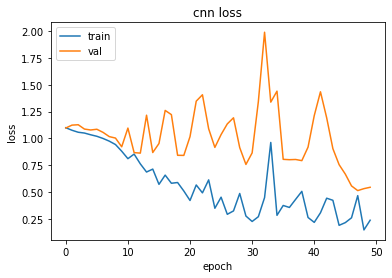

In [ ]:
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('cnn loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# change shape and stuff
train_inputs_np = tfds.as_numpy(train_inputs)
train_inputs_np = train_inputs_np.reshape(train_inputs_np.shape[0], train_inputs_np.shape[1] * train_inputs_np.shape[2] * train_inputs_np.shape[3])
train_targets_np = tfds.as_numpy(train_targets)

test_inputs_np = tfds.as_numpy(test_inputs)
test_inputs_np = test_inputs_np.reshape(test_inputs_np.shape[0], test_inputs_np.shape[1] * test_inputs_np.shape[2] * test_inputs_np.shape[3])
test_targets_np = tfds.as_numpy(test_targets)

In [ ]:
# SVM classifier
grid = {
    'C':[0.1,1,10],
    'kernel':["linear","poly"],
    'gamma':[0.01,0.1,1],
    'degree':[3,5,7]
}

svm = SVC()
svm_grid = GridSearchCV(svm, grid, cv=5)
svm_grid.fit(train_inputs_np, train_targets_np) # fit the data

print("Best Parameters:", svm_grid.best_params_)
print("Training Accuracy:", svm_grid.best_score_)
print("Test Accuracy:", svm_grid.score(test_inputs_np, test_targets_np)) # check against traning accuracy

df = pd.concat([pd.DataFrame(svm_grid.cv_results_["params"]), pd.DataFrame(svm_grid.cv_results_["mean_test_score"], columns=["Accuracy"])], axis=1)
df = df.sort_values(by=['Accuracy'], ascending=False) #sort by accuracy in descending order
print(df)

Best Parameters: {'C': 0.1, 'degree': 3, 'gamma': 0.01, 'kernel': 'linear'}
Training Accuracy: 0.8666666666666666
Test Accuracy: 0.6263440860215054
       C  degree  gamma  kernel  Accuracy
0    0.1       3   0.01  linear  0.866667
25   1.0       5   0.01    poly  0.866667
1    0.1       3   0.01    poly  0.866667
28   1.0       5   1.00  linear  0.866667
29   1.0       5   1.00    poly  0.866667
30   1.0       7   0.01  linear  0.866667
32   1.0       7   0.10  linear  0.866667
34   1.0       7   1.00  linear  0.866667
36  10.0       3   0.01  linear  0.866667
37  10.0       3   0.01    poly  0.866667
38  10.0       3   0.10  linear  0.866667
39  10.0       3   0.10    poly  0.866667
40  10.0       3   1.00  linear  0.866667
41  10.0       3   1.00    poly  0.866667
42  10.0       5   0.01  linear  0.866667
43  10.0       5   0.01    poly  0.866667
44  10.0       5   0.10  linear  0.866667
45  10.0       5   0.10    poly  0.866667
46  10.0       5   1.00  linear  0.866667
47  10.0    

In [ ]:
# K-NN classifier

grid = {
    'n_neighbors':[1,5,8,12,15,20,25]
}

knn = KNeighborsClassifier() #default is 5
knn_grid = GridSearchCV(knn, grid, cv=5)
knn_grid.fit(train_inputs_np, train_targets_np) # fit the data

print("Best Parameters:", knn_grid.best_params_)
print("Training Accuracy:", knn_grid.best_score_)
print("Test Accuracy:", knn_grid.score(test_inputs_np, test_targets_np)) # check against traning accuracy

df = pd.concat([pd.DataFrame(knn_grid.cv_results_["params"]), pd.DataFrame(knn_grid.cv_results_["mean_test_score"], columns=["Accuracy"])], axis=1)
df = df.sort_values(by=['Accuracy'], ascending=False) #sort by accuracy in descending order
print(df)

Best Parameters: {'n_neighbors': 1}
Training Accuracy: 0.6476190476190476
Test Accuracy: 0.6209677419354839
   n_neighbors  Accuracy
0            1  0.647619
2            8  0.580952
1            5  0.528571
3           12  0.500000
5           20  0.438095
6           25  0.438095
4           15  0.404762


In [ ]:
#Stacking Ensemble Learning

# create a SVM classifier
svm_stacking = SVC(C=1, kernel='linear')

# KNN classifier
knn_stacking = KNeighborsClassifier()

# Randomforest classifier
forest_stacking = RandomForestClassifier(n_estimators=100)

# MLP classifier
mlp_stacking = MLPClassifier(alpha=1, max_iter=1000)

# Stacking classifier
stacking = [
     ('svm', svm_stacking),
     ('knn', knn_stacking),
     ('forest', forest_stacking)
]
stacking_el = StackingClassifier(estimators=stacking,final_estimator=mlp_stacking,cv=5)

# Fit the Stacking classifier; Print the scores
stacking_el.fit(train_inputs_np, train_targets_np)
print(f"Stacking classifier training Accuracy: {stacking_el.score(train_inputs_np, train_targets_np)*100:0.2f}%")
print(f"Stacking classifier test Accuracy: {stacking_el.score(test_inputs_np, test_targets_np)*100:0.2f}%")

Stacking classifier training Accuracy: 100.00%
Stacking classifier test Accuracy: 62.90%
